# <span style = 'color:darkred'> Set notebook to full width </span style>

In [0]:
from py4j.java_gateway import JavaGateway, GatewayParameters
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=25333))

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# <span style = 'color:darkred'> Notebook structure </span style>

- ### <a href=#imports> Imports  </a>
- ### <a href=#read_in> Reading in (sub)set </a>
- ### <a href=#tickers_ipo_extraction> Extracting ticker formatted strings and tweets containing IPO </a>
- ### <a href=#redun_columns> Drop standard redundant columns after checking</a>
- ### <a href=#expand_subcols> Expand the subcolumns that do not contain WrapperArrays </a>
- ### <a href=#check_and_drop_redundant_cols> Check for non-standard redundant columns and drop them </a>
- ### <a href=#none> ... </a>



# <span style = 'color:darkred'> Imports </span style>

In [0]:
import os
import sys
import csv
#os.environ['SPARK_HOME'] = 'D:/School/STAGE_BP/spark'
#import findspark
#findspark.init(spark_home = "/home/sachadubrulle/spark-2.1.0")
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")

SparkSession initialized


# <span style = 'color:darkred'> To do </span style>

- Add remaining 7000 tweets that are not yet included for 2016
- Based on tweets with a known ticker -> find tweets based on language analysis that talk about IPO without necessarilty containing a tickerm

# <span style = 'color:darkred'> Imports </span style> <a name='imports' />

In [0]:
# Python imports
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import glob

# Spark imports
from pyspark.sql.functions import udf, year, month, dayofmonth, explode, lower, regexp_extract, split, upper
from pyspark.sql.types import *
import time
from datetime import datetime

# <span style = 'color:darkred'> ETL </span style> <a name='read_in' />

## <span style = 'color:green'> Reading in tweets </span style> <a name='read_in' />

In [0]:
from IPython.display import display  
from ipywidgets import FloatProgress  
import time


# Hadoop file path
path = "/home/mma/Downloads/IPO_Mining/*.json"

df = (spark.read.json(path))

original_columns = df.columns

df = (df.withColumnRenamed("id_str", "tweet_id_str") #rename to avoid confusion with user_id, retweet_id, ...
        .withColumn("user_id_str", df.user.id_str) 
        .select("tweet_id_str","created_at",  "text", "user_id_str", "entities", "lang", "in_reply_to_status_id_str", "in_reply_to_user_id_str", "is_quote_status")
     )

print("The original columns were: {}".format(original_columns))


FloatProgress(value=0.0)

The original columns were: ['contributors', 'coordinates', 'created_at', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'scopes', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries']


In [0]:
df.show()

+------------------+--------------------+--------------------+-----------+--------------------+----+-------------------------+-----------------------+---------------+
|      tweet_id_str|          created_at|                text|user_id_str|            entities|lang|in_reply_to_status_id_str|in_reply_to_user_id_str|is_quote_status|
+------------------+--------------------+--------------------+-----------+--------------------+----+-------------------------+-----------------------+---------------+
|727979781690671104|Wed May 04 21:54:...|RT @zaynmalik: Fu...| 2262979654|[[],, [], [[twitt...|  en|                     null|                   null|           true|
|727979781531258881|Wed May 04 21:54:...|RT @zaynmalik: Fu...|  353980481|[[],, [], [[twitt...|  en|                     null|                   null|           true|
|727979781757779968|Wed May 04 21:54:...|RT @zaynmalik: Fu...| 2598224066|[[],, [], [[twitt...|  en|                     null|                   null|           true

In [0]:
df.select("entities").show(10, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|entities                                                                                                                                                                                   |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[],, [], [[twitter.com/thotofmind/sta…, https://twitter.com/thotofmind/status/727722961499721729, [31, 54], https://t.co/QLjSXusd1j]], [[176566242, 176566242, [3, 13], zayn, zaynmalik]]]|
|[[],, [], [[twitter.com/thotofmind/sta…, https://twitter.com/thotofmind/status/727722961499721729, [31, 54], https://t.co/QLjSXusd1j]], [[176566242, 176566242, [3, 13], zayn, zaynmalik]]]|
|[[],, [], [[twitter.com/thotofmind/sta…, https://

In [0]:
#df.printSchema()
#df.select("retweeted_status").rdd.take(1)

## <span style = 'color:darkgreen'> Extracting tickers & presence of IPO out of text </span style> <a name='tickers_ipo_extraction' />

 - containing $-sign in the text or containing ipo

In [0]:
# REGEX to extract tickers or presence of IPO
ticker_expression_no_numbers = '(\s\$[A-Za-z]{1,6})+'
ticker_expression_including_numbers = '\$[A-Za-z0-9]{1,6}'
ipo_expression = '#ipo|ipo|#IPO|IPO'

df_tickers = (df.withColumn("tickers", regexp_extract('text', ticker_expression_no_numbers, 0))
                .withColumn("contains_ipo", regexp_extract('text', ipo_expression, 0))
            )

In [0]:
# Filter full dataset for tweets that contain either a ticker-pattern or the IPO pattern
df_tickers_and_ipo = df_tickers.filter((df_tickers["tickers"] != "") | (df_tickers["contains_ipo"] != ""))

print("There are {} tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign".format(df_tickers.count()))

#df_tickers_and_ipo.select("tweet_id_str", "contains_ipo", "tickers").show(5)
#df.createOrReplaceTempView("dfSQL")

There are 7064700 tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign


In [0]:
# Filter out the tweets that contain one or multiple tickers
df_tickers = (df_tickers_and_ipo.filter(df_tickers["tickers"] != ""))

""
df_tickers = (df_tickers.select("tweet_id_str", "user_id_str", "text", "created_at","lang", split(df_tickers.tickers, '\s\$').alias('tickers')))

df_tickers = df_tickers.withColumn("ticker", explode(df_tickers.tickers)).select("tweet_id_str", "user_id_str","text", "ticker", "created_at", "lang")
df_tickers = df_tickers.filter(df_tickers.ticker != "")

aggregated_tickers = (df_tickers.withColumn("ticker", upper(df_tickers.ticker))
                                .groupBy("ticker").count()
                                .withColumnRenamed('count', "ticker_occurence")
                     )
aggregated_tickers = aggregated_tickers.sort(aggregated_tickers.ticker_occurence.desc())

#aggregated_tickers.coalesce(1).write.csv("ticker_occurence_2016", mode = "overwrite")


In [0]:
aggregated_tickers.rdd.take(10)

[Row(ticker='TF', ticker_occurence=454),
 Row(ticker='RXSF', ticker_occurence=440),
 Row(ticker='HUM', ticker_occurence=245),
 Row(ticker='UHLN', ticker_occurence=224),
 Row(ticker='ONOV', ticker_occurence=197),
 Row(ticker='EDIT', ticker_occurence=150),
 Row(ticker='VKTX', ticker_occurence=138),
 Row(ticker='IPO', ticker_occurence=137),
 Row(ticker='IGN', ticker_occurence=137),
 Row(ticker='RRR', ticker_occurence=131)]

In [0]:
# Tickers voor Jolien

for t in ("ARA", "VKTX", "RRR", "RETA", "HTGM", "OMF", "BOLD", "ESES", "SBPH"):
    one_ticker_df = df_tickers.filter(df_tickers.ticker == t)
    print("Ticker: {}".format(t))
    print(one_ticker_df.count())
    one_ticker_df.show(10)
    #one_ticker_df.write.json("{}_tweets.json".format(t), mode = "overwrite")
    
    

Ticker: ARA
54
+------------------+------------------+--------------------+------+--------------------+----+
|      tweet_id_str|       user_id_str|                text|ticker|          created_at|lang|
+------------------+------------------+--------------------+------+--------------------+----+
|722040892278878209|711892809993854976|RT @WrigleyTom: E...|   ARA|Mon Apr 18 12:35:...|  en|
|730866019892232192|          23214029|Curious to hear 1...|   ARA|Thu May 12 21:03:...|  en|
|732682676965146624|         829770277|1619 #BMV  #TRMX ...|   ARA|Tue May 17 21:22:...|  ro|
|735766699031465985|        2743641378|Q2 2016 EPS Estim...|   ARA|Thu May 26 09:37:...|  en|
|754242802167476224|        4877831176|I love them too M...|   ARA|Sat Jul 16 09:14:...|  en|
|737179683981131776|        3009839990|low 2.50s must ho...|   ARA|Mon May 30 07:11:...|  en|
|734620252496093184|        1979190776|Recent Investment...|   ARA|Mon May 23 05:41:...|  en|
|734620255197274112|        1979190776|Recent

21
+------------------+-----------+--------------------+------+--------------------+----+
|      tweet_id_str|user_id_str|                text|ticker|          created_at|lang|
+------------------+-----------+--------------------+------+--------------------+----+
|730284726557261824| 2743641378|Eco-Stim Energy S...|  ESES|Wed May 11 06:33:...|  en|
|730906759859187712| 2338882843|Eco-Stim Energy S...|  ESES|Thu May 12 23:45:...|  en|
|738439660955938819| 2920726547|Energy/Materials ...|  ESES|Thu Jun 02 18:38:...|  es|
|731067557457866752|   25292321|Eco-Stim Energy S...|  ESES|Fri May 13 10:24:...|  en|
|736167739010736128|   61661638|Eco-Stim Energy S...|  ESES|Fri May 27 12:10:...|  en|
|749944045976387586| 2525892205|Eco-Stim Energy S...|  ESES|Mon Jul 04 12:32:...|  en|
|745195579689603073|   25292321|Eco-Stim Energy S...|  ESES|Tue Jun 21 10:04:...|  en|
|715517715348258816| 3984480800|My friend made $4...|  ESES|Thu Mar 31 12:34:...|  en|
|749943766233079808| 2266388972|Eco-Stim

In [0]:
#df.filter("Viking Therapeutics" in df.text)
#df.filter(df.text.contains("Viking Therapeutics")).collect() # DEZE WERK LOKAAL WEL MAAR NIET OP SERVER ??

[Row(tweet_id_str='732082562852622336', created_at='Mon May 16 05:37:39 +0000 2016', text='Q2 2016 Earnings Estimate for Viking Therapeutics Inc Issued By Feltl &amp; Co. (VKTX) https://t.co/Th46aAEAqI', user_id_str='2298709746', entities=Row(hashtags=[], media=None, symbols=[], urls=[Row(display_url='ift.tt/1V5uJJC', expanded_url='http://ift.tt/1V5uJJC', indices=[87, 110], url='https://t.co/Th46aAEAqI')], user_mentions=[]), lang='en', in_reply_to_status_id_str=None, in_reply_to_user_id_str=None, is_quote_status=False),
 Row(tweet_id_str='719561958140157953', created_at='Mon Apr 11 16:25:14 +0000 2016', text='Viking Therapeutics $VKTX Stock Rising on Positive Clinical Results https://t.co/mg8frTRhsS #StockAction', user_id_str='2342591485', entities=Row(hashtags=[Row(indices=[92, 104], text='StockAction')], media=None, symbols=[Row(indices=[20, 25], text='VKTX')], urls=[Row(display_url='dlvr.it/L24NXQ', expanded_url='http://dlvr.it/L24NXQ', indices=[68, 91], url='https://t.co/mg8frTRhsS

In [0]:
replaceSemicolon = udf(lambda x: x.replace(";", ","))

In [0]:
edit_df = df.withColumn("text", replaceSemicolon(df.text))

In [0]:
#edit_df = edit_df.withColumn("text", replaceSemicolon(edit_df.text))

In [0]:
edit_df.rdd.take(1)

[Row(tweet_id_str='727979781690671104', created_at='Wed May 04 21:54:39 +0000 2016', text='RT @zaynmalik: Fuck yeaaaah!!  https://t.co/QLjSXusd1j', user_id_str='2262979654', entities=Row(hashtags=[], media=None, symbols=[], urls=[Row(display_url='twitter.com/thotofmind/sta…', expanded_url='https://twitter.com/thotofmind/status/727722961499721729', indices=[31, 54], url='https://t.co/QLjSXusd1j')], user_mentions=[Row(id=176566242, id_str='176566242', indices=[3, 13], name='zayn', screen_name='zaynmalik')]), lang='en', in_reply_to_status_id_str=None, in_reply_to_user_id_str=None, is_quote_status=True)]

In [0]:
#edit_df.write.csv("editas_tweets.csv", mode = "overwrite", sep = ";")
edit_df.write.csv("/mnt/bdata1/twitter/editas_tweets3.csv").mode('overwrite').delimiter(";")

In [0]:
edit_df.count()


7064700

In [0]:
users_df = (df_tickers.select("user_id_str")
                   .groupBy("user_id_str")
                   .count()
                   .withColumnRenamed("count", "nbr_tweets_with_ticker")
        )

In [0]:

stockbard_id = "738550990698336261"

In [0]:

users_df = (users_df.sort(users_df.nbr_tweets_with_ticker.desc())
            )

users_df.filter(users_df.user_id_str != stockbard_id)

users_df.count()

users_df.show(10)

+------------------+----------------------+
|       user_id_str|nbr_tweets_with_ticker|
+------------------+----------------------+
|         528770977|                   838|
|        2997788563|                   681|
|        2581019786|                   420|
|738550990698336261|                   188|
|        4584354895|                   128|
|        2616445050|                   121|
|        2534863784|                    93|
|         287966215|                    74|
|          23059499|                    73|
|          49637104|                    73|
+------------------+----------------------+
only showing top 10 rows



# <span style = 'color:darkred'> Language </span style>

In [0]:

df_lang = (df_tickers.select("lang")
                .groupBy("lang")
                .count()
                .withColumnRenamed("count", "languageCount")
                .orderBy("count", ascending = False)
    )


df_lang.show(10)


+----+-------------+
|lang|languageCount|
+----+-------------+
|  en|         9290|
|  in|          474|
|  pt|          362|
| und|          184|
|  nl|          151|
|  de|          140|
|  es|          105|
|  tl|          101|
|  ht|          100|
|  fr|           65|
+----+-------------+
only showing top 10 rows



# <span style = 'color:darkred'> Distribution of tweets over time </span style>

In [0]:
import pandas as pd

In [0]:
#pd.read_csv()

In [0]:
# UDF to convert created_at (String) to created_at_datetime (TimestampType)

def created_at_string_to_timestamp(x):
    return datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')

to_datetimestamp =  udf (created_at_string_to_timestamp, TimestampType())

In [0]:
df = df_tickers
df

DataFrame[tweet_id_str: string, user_id_str: string, text: string, ticker: string, created_at: string, lang: string]

In [0]:
get_ipython().run_cell_magic('time', '', '\ndf = df.withColumn(\'created_at_timestamp\', to_datetimestamp(df.created_at))\n\ndf_time = (df.select(year("created_at_timestamp").alias("year"),\n                 month("created_at_timestamp").alias("month"),\n                 dayofmonth("created_at_timestamp").alias("dayofmonth")\n                 )\n            .groupBy("dayofmonth", "month", "year")\n            .count()\n            .withColumnRenamed("count", "tweets_per_day")\n            .orderBy("year", "month", "dayofmonth", ascending = True)\n)\n\ndf_time_pandas = df_time.toPandas()\ndf_time_pandas[\'date\'] = df_time_pandas.apply(lambda x: datetime.strptime(\'%s/%s/%s\' % (x.dayofmonth, x.month, x.year), \'%d/%m/%Y\'),axis=1)\n\n#df_time_pandas')


Wall time: 11min 3s


In [0]:
df_time_pandas["tweets_per_day_thousands"] = df_time_pandas["tweets_per_day"].apply(lambda x: x/float(1000))

def labels(x):
    if x.day == 1:
        return str(x)[0:10]
    else:
        return " "

df_time_pandas["label_x_axis"] = df_time_pandas["date"].apply(lambda x: labels(x))
df_time_pandas


,dayofmonth,month,year,tweets_per_day,date,tweets_per_day_thousands,label_x_axis
0,30,3,2016,68,2016-03-30,0.068,
1,31,3,2016,124,2016-03-31,0.124,
2,1,4,2016,89,2016-04-01,0.089,2016-04-01
3,2,4,2016,251,2016-04-02,0.251,
4,3,4,2016,72,2016-04-03,0.072,
5,4,4,2016,145,2016-04-04,0.145,
6,5,4,2016,140,2016-04-05,0.140,
7,6,4,2016,96,2016-04-06,0.096,
8,7,4,2016,119,2016-04-07,0.119,
9,8,4,2016,240,2016-04-08,0.240,


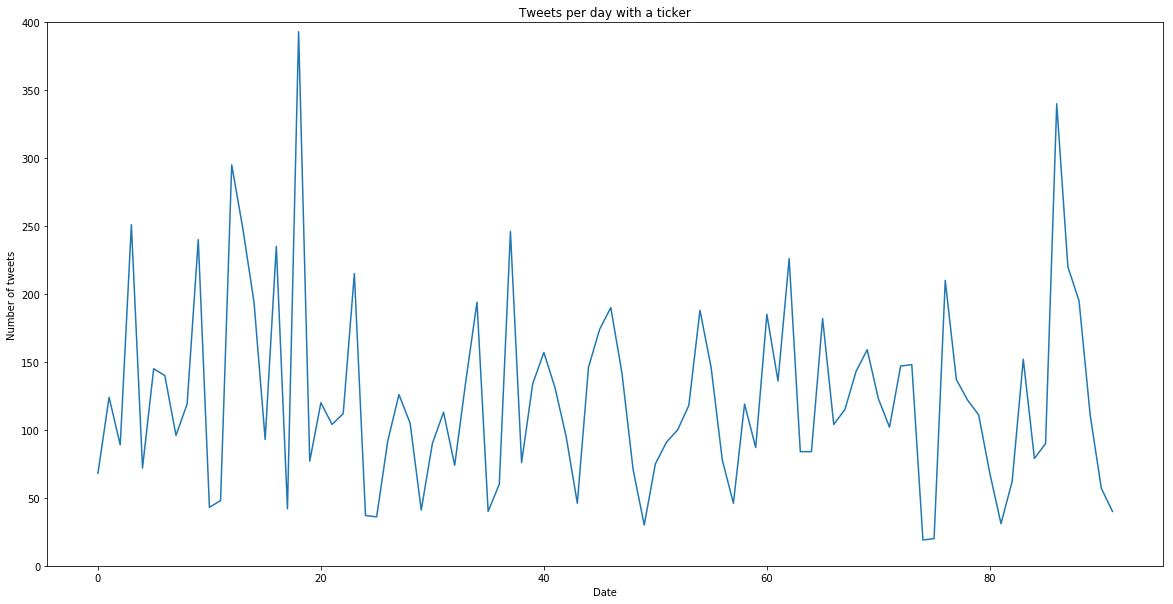

In [0]:
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(df_time_pandas.tweets_per_day)

plt.xlabel("Date")
plt.ylabel("Number of tweets")

plt.ylim(ymin = 0, ymax = 4000)

plt.title("Tweets per day with a ticker")

plt.show()

# <span style = 'color:darkred'> Hashtags </span style>

In [0]:
#df_hashtags = (df.select('tweet_id_str', "entities")
#                 .withColumnRenamed("text", "hashtag_array")
#              )

#df_hashtags = df_hashtags.select("tweet_id_str", explode(df_hashtags.hashtag_array).alias("hashtags"))

#df_hashtags = df_hashtags.select("tweet_id_str", lower(df_hashtags['hashtags']).alias("hashtags"))


In [0]:
#df.show()

In [0]:

#df_hashtags.createOrReplaceTempView("hashtagsSQL")
 
#df_top = spark.sql("SELECT hashtags, count(hashtags) as count FROM hashtagsSQL GROUP BY hashtags ORDER BY 2 DESC ").show()


In [0]:
df.count()

11395

In [0]:
df_time_pandas.count()

dayofmonth                  92
month                       92
year                        92
tweets_per_day              92
date                        92
tweets_per_day_thousands    92
label_x_axis                92
dtype: int64